<a id="0"></a> <br>
 # Table of Contents [Statistics 627 Project - Jared Klein - American University](#1)     
1. [Introduction](#1)
    1. [Setting the Stage](#2) 
    1. [Target, Data Source, and Tools Overview](#3)     
        1. [Imports](#4)     
        1. [Preprocessing](#5)     
        1. [Variable Exploration, More Preprocessing, and Train-Test Splits](#6)     
1. [Multicollinearity Analysis](#7) 
    1. [Variable Inflation Factor Analysis Part 1](#8)       
        1. [Collinear Column Analysis](#9)      
        1. [Lasso Regression Part 1](#10)     
        1. [Principal Component Analysis Part 1](#11)         
1. [Model Building](#12)             
    1. [Random Forest Regressor with PCA Transformed Data](#13)
    1. [Standard Ordinary Least Squares Regression](#14)
        1. [Using StatsModels Package](#15)
1. [Re-Evaluating and Improving Models](#16)
    1. [Variable Inflation Factor Analysis Part 2](#17)
    1. [Lasso Regression Part 2 (Low Dimensional Features)](#18)
    1. [Ordinary Least Squares Regression (Low Dimensions and Polynomial Regression)](#19)
    1. [Random Forest Regressor (Low Dimension)](#20)
    1. [With PCA w/o Specifying Saved Variance as .95](#21)
1. [Conclusion](#22) 
    1. [Possible Improvements](#23)     
    


<a id="1"></a> <br>
# Introduction
[back to the top](#0)

<a id="2"></a> <br>
## Setting the Stage
[back to the top](#0)

   There is no way to sugarcoat this. My beloved San Jose Sharks, the franchise that only missed the playoffs 3 times between 2000 and 2020, made it beyond the conference semi-finals 12 times in that span with an appearance in the Stanley Cup final in 2016, won the Presidents Trophy in 2009, and won 6 Pacific Division titles (albeit before the most recent league realignment), are now terrible. In fact, describing this team now as terrible may be an understatement. “Dreadful” or “horrific” may be better terms to describe the former juggernaut franchise that was so dominant for 20 years on the back on legends like Joe Thornton, Owen Nolan, Patrick Marleau, Evgeni Nabakov, and Joe Pavelski. As of this writing, San Jose has given up 13 goals in the last two games, sport a goal difference of -14 while surrendering 82 goals in 23 games. They are 31st in the league with a .370 points percentage only ahead of the lowly Anaheim Ducks. 

This is far from surprising when you watch them play. A porous defense and a knack for turning pucks over at the blueline will kill even the worst of beer league teams.  

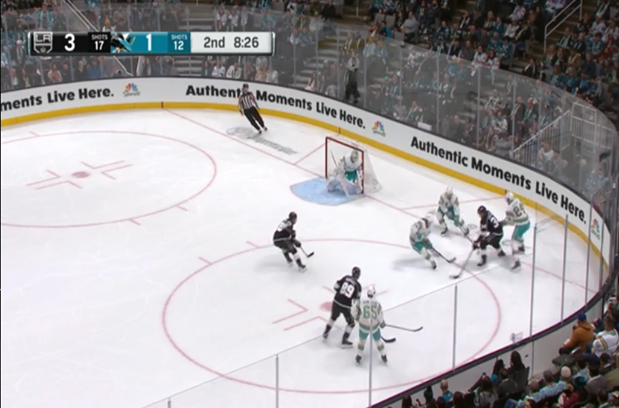

*Figure 1: Would anyone of the backchecking forwards like to pick up the man in front of the net?*

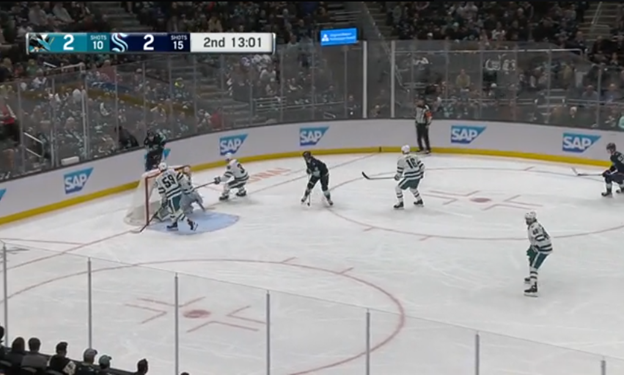

*Figure 2: Surely you don't need two defenders to pressure the man behind the net?*

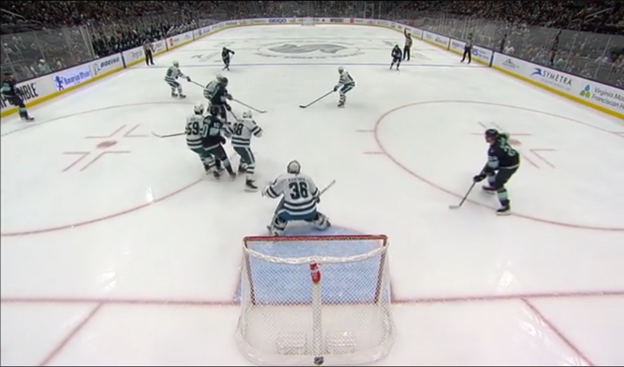

*Figure 3: Moses would be proud, he too excelled at parting sea creatures for passing lanes.*

So, what to do? How do we solve this conundrum of making the Sharks a better team? This is new Sharks General Manager Mike Grier’s challenge; however, this is my school project and I like to fantasize a little bit (though, my own fantasy hockey team is at the bottom of the league right now, so we’ll ignore my obvious lack of credentials to make any decision on hockey related things). I am not a miracle worker (though I have never tried to make water into wine), but I do have a particular set of skills that allow me build machine learning models to determine what players might be able to help improve the Sharks, theoretically. 

<a id="3"></a> <br>
## Target, Data Source, and Tools Overview

In this project, I will use a player’s CorsiFor percentage (CF%) focused on even strength (or 5-on-5) play as the response variable we are trying to predict. This is a measure of how well the team controls play while that player is on the ice based on shots, blocked shots, and misses. The logic here being that if we can project the players who control play during the most common situation in hockey (5-on-5) we will be able to target those players to help the team. 

This logic and the use of the CF% has flaws of course such as ability to acquire such players in a salary cap era or how CF% hands out false positive rewards for average players playing with good players and false negative rewards for good players playing with bad ones. However, I am not a statistician (though I am working on it), I do not have the means to access higher quality statistics and data, and, in case you did not catch on yet, this is MY fantasy. So, lets live a little! 

The data I am using for this exercise is courtesy of Hockey-Reference.com. This was the highest quality of data I could obtain given my limited means and includes a sample of 1004 players and 43 features for model building. A dataset for basic, advanced, and miscellaneous statistics were joined on the players name. 

I have chosen to use python's suite of data science tools such as Sci-Kit Learn, Statsmodels API, pandas, and numpy for a two reasons. First, these libraries are incredibly robust and are extremely common in the machine learning and analytics communities given their open source nature. They are also Second, this allows me to piggy back off another project I have been working on (utilizing the AWS cloud which you can see on my GitHub: https://github.com/j4klein95/predicting-scores-hck). Plus, they are just fun to use (alright that's three reasons, sue me). 

<a id="4"></a> <br>
### Imports
[back to the top](#0)

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 400
pd.options.display.max_columns = 70
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import seaborn as sns
import matplotlib.pyplot as plt
import rfpimp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLarsCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.feature_selection import mutual_info_regression
from sklearn import tree


from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


# from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [2]:
import random

np.random.seed(42)
random.seed(42)

<a id="5"></a> <br>
### Preprocessing
[back to the top](#0)

In [3]:
df = pd.read_csv("..\\data\\refined.csv")

In [4]:
df.head()

,Player,Age,Team,Position,GamesPlayed,Goals,Assists,Points,PlusMinus,PenaltyMinutes,PointShare,EV,PP,SH,GW,EV.1,PP.1,SH.1,Shots,S%,TOI,ATOI,BLK,HIT,FOW,FOL,FO%,CF,CA,CF%,CF% rel,FF,FA,FF%,FF% rel,oiSH%,oiSV%,PDO,oZS%,dZS%,TOI/60,TOI(EV),TK,GV,SAtt.,Thru%,Pos,GP,GoalsCreated,GoalsPerGame,AssistsPerGame,PointsPerGame,GoalsCreatedPerGame,PenaltyMinutesPerGame,ShotsPerGame,AdjustedGoals,AdjustedAssists,AdjustedPts,AdjustedGoalsCreated,TGF,PGF,TGA,PGA,xGF,xGA,ExpectedPlusMinus,OPS,DPS,PointShares
0,Nicholas Abruzzese,22,TOR,C,9,1,0,1,-1,2,0.000,1,0,0,1,0,0,0,8,12.500,92,10:13,3,7,2,5,28.600,69,72,48.900,-2.800,46,59,43.800,-8.900,5.700,92.500,98.200,46.300,53.700,10:13,9:11,0,3,12,66.700,C,9,1,0.110,0.000,0.110,0.060,0.220,0.890,1,0,1,1,2,0,3,0,3.500,3.200,0.200,-0.100,0.000,0.000
1,Noel Acciari,30,FLA,C,20,3,5,8,2,11,0.600,3,0,0,1,5,0,0,32,9.400,240,11:59,16,48,84,82,50.600,204,165,55.300,-1.500,150,119,55.800,-0.200,9.600,89.400,99.100,52.000,48.000,11:59,10:38,8,6,52,61.500,C,20,3,0.150,0.250,0.400,0.150,0.550,1.600,3,5,8,3,11,0,13,4,9.400,6.700,2.700,0.400,0.200,0.600
2,Calen Addison,21,MIN,D,15,2,2,4,-4,2,0.300,2,0,0,0,2,0,0,17,11.800,207,13:47,6,12,0,0,NaN,199,150,57.000,6.300,144,119,54.800,4.200,9.700,84.700,94.400,50.500,49.500,13:47,12:16,0,1,36,47.200,D,15,2,0.130,0.130,0.270,0.110,0.130,1.130,2,2,4,2,12,1,15,0,9.800,6.900,3.000,0.300,0.000,0.300
3,Andrew Agozzino,31,OTT,LW,1,0,0,0,0,0,0.000,0,0,0,0,0,0,0,1,0.000,7,6:52,0,4,1,2,33.300,8,4,66.700,26.700,5,2,71.400,29.100,0.000,100.000,100.000,50.000,50.000,6:52,6:52,0,0,1,100.000,LW,1,0,0.000,0.000,0.000,0.000,0.000,1.000,0,0,0,0,0,0,0,0,0.100,0.200,-0.200,0.000,0.000,0.000
4,Jack Ahcan,24,BOS,D,6,1,0,1,-3,0,0.100,0,1,0,0,0,0,0,5,20.000,96,16:02,5,8,0,0,NaN,93,70,57.100,5.300,69,52,57.000,3.700,0.000,92.100,92.100,59.200,40.800,16:02,15:29,1,4,14,35.700,D,6,1,0.170,0.000,0.170,0.090,0.000,0.830,1,0,1,1,1,1,3,0,3.900,2.800,1.200,0.100,0.000,0.100


So lets do a little bit of setup. We'll first take a look at the columns, convert time stamps to seconds for time on ice, and filter for players who have competed in at least a quarter of the season which is around 20 games. 

In [5]:
df.columns

Index(['Player', 'Age', 'Team', 'Position', 'GamesPlayed', 'Goals', 'Assists',
       'Points', 'PlusMinus', 'PenaltyMinutes', 'PointShare', 'EV', 'PP', 'SH',
       'GW', 'EV.1', 'PP.1', 'SH.1', 'Shots', 'S%', 'TOI', 'ATOI', 'BLK',
       'HIT', 'FOW', 'FOL', 'FO%', 'CF', 'CA', 'CF%', 'CF% rel', 'FF', 'FA',
       'FF%', 'FF% rel', 'oiSH%', 'oiSV%', 'PDO', 'oZS%', 'dZS%', 'TOI/60',
       'TOI(EV)', 'TK', 'GV', 'SAtt.', 'Thru%', 'Pos', 'GP', 'GoalsCreated',
       'GoalsPerGame', 'AssistsPerGame', 'PointsPerGame',
       'GoalsCreatedPerGame', 'PenaltyMinutesPerGame', 'ShotsPerGame',
       'AdjustedGoals', 'AdjustedAssists', 'AdjustedPts',
       'AdjustedGoalsCreated', 'TGF', 'PGF', 'TGA', 'PGA', 'xGF', 'xGA',
       'ExpectedPlusMinus', 'OPS', 'DPS', 'PointShares'],
      dtype='object')

In [92]:
df.shape

(721, 43)

In [6]:
def get_seconds(time_str):
    # split in hh, mm, ss
    mm, ss = time_str.split(':')
    return int(mm) * 60 + int(ss)

In [7]:
df['TOI/60'] = df['TOI/60'].apply(lambda x: get_seconds(x))
df['ATOI'] = df['ATOI'].apply(lambda x: get_seconds(x))
df['TOI(EV)'] = df['TOI(EV)'].apply(lambda x: get_seconds(x))

In [8]:
# Select only players that have played more than 10 games
df = df.loc[(df['GamesPlayed'] >= 20)]

<a id="6"></a> <br>
### Variable Exploration, More Preprocessing, and Train-Test Splits
[back to the top](#0)

Now, we get to take a look at the pearson correlation coefficients of these variables as they pertain to our target variable CF%

<AxesSubplot:>

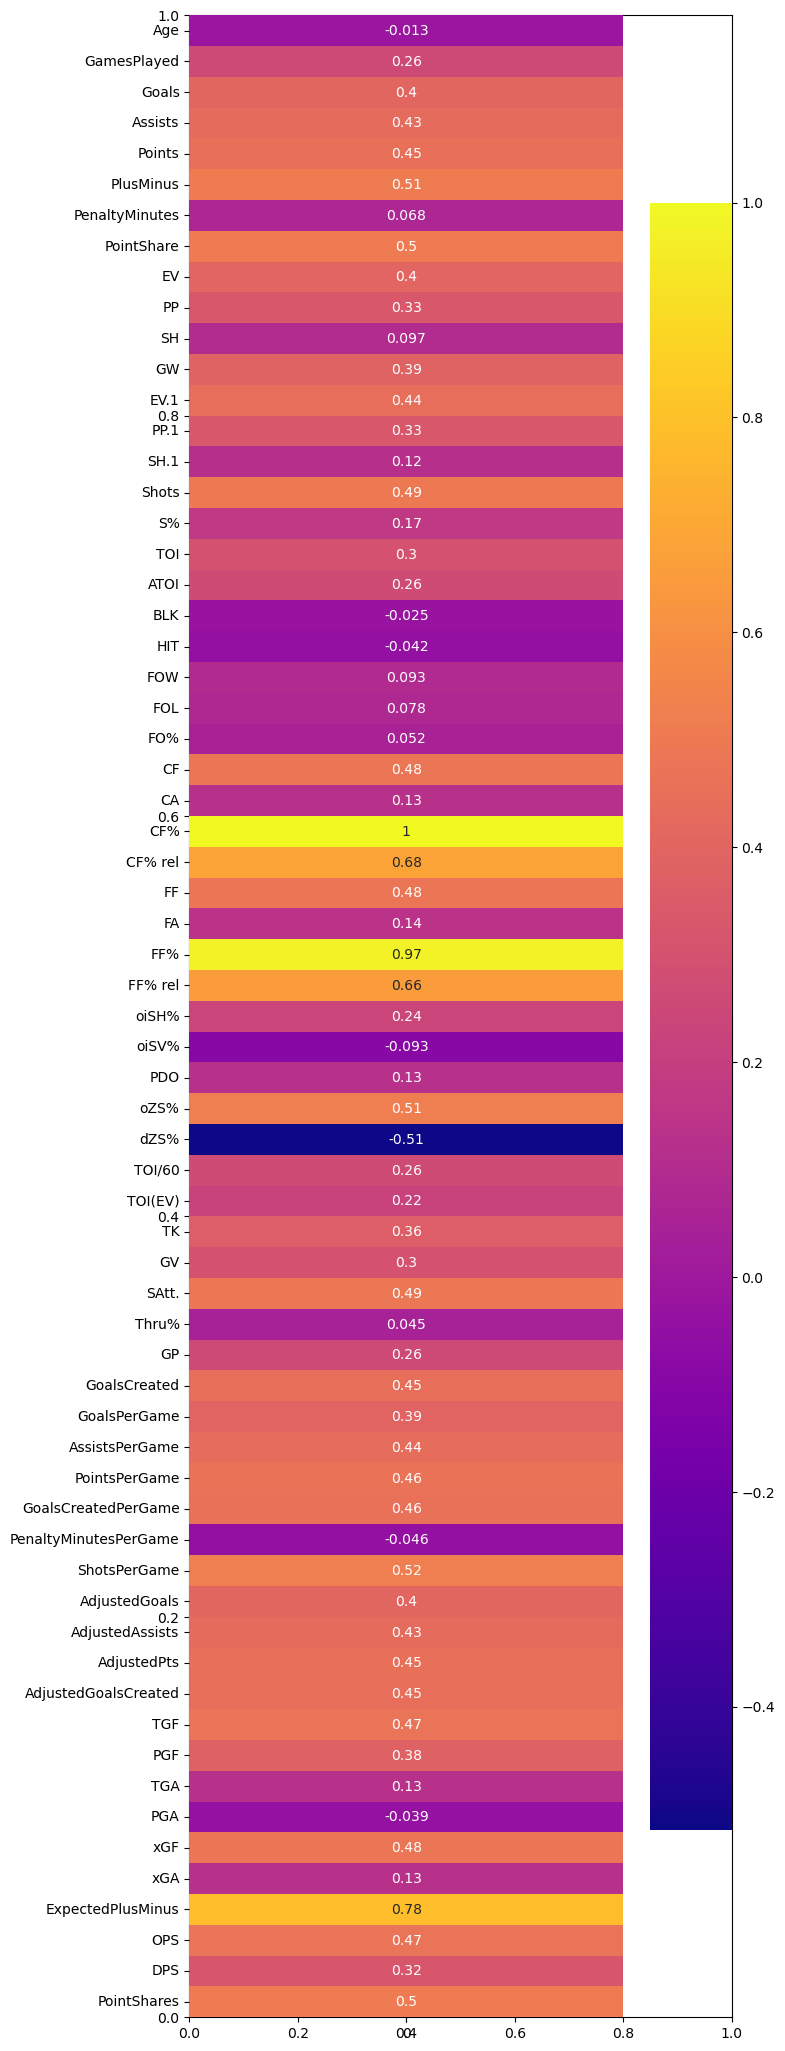

In [9]:
plt.subplots(figsize=(7, 26))
ax = plt.axes()
corr = df.corrwith(df['CF%'])
corr = pd.DataFrame(corr)

sns.heatmap(corr,
            annot=True,
            cmap = plt.cm.plasma)

*Figure 4: An overview of correlation coefficients for our target variable.*

So we get some pretty interesting insight into the potential relationships between **CF%** and the rest of the features in our dataset. It seems like faceoff related stats and short handed goals appear to have big coefficients. Those aren't the only high coefficients, and there is reason to be concerned. Some of these features, such as **FF** (Fenwick for which ignores blocked shots) and **CF** (the actual count of shots+blocks+misses) are used in the calculation of **CF%** or are extremely similar to the production of the stat creating potential issues of multicolinnearity. Plus, as I just pointed out with stats such as short-handed goals, there are features here that are not relevant to even strength play or I have good reason to not include such as time on ice. I'm not interested in how long a player spends on the ice, just with what he accomplishes while on it. 

I'm dropping **Team**, **Position**, and Face-off related features from the data set. Ultimately, I want the team not to have any influence on predicted **CF%** since, in my fantasy, I would be looking to acquire high **CF%** players from other teams. **Position** and Face-off related stats are to be removed since I do not want the models to be biased by a position or whether or not a player wins a lot of faceoffs (especially since a good number of players do not take face-offs). Though, it might be worth exploring keeping the latter features more given that, at least theoretically, winning faceoffs more often than not mean you start with the puck and therefore have early control of play after a stoppage.

Further, we must remove all **fenwick** and **corsi** related stats since the former is calculated similarly to how CF% is, and the latter is directly derived from those features thus creating issues multicollinearity. 

As I alluded to previously, I am also removing all features that have to do with non 5-on-5 play given that CF% is specific to even strength play. That means **penalty minutes**, **short-handed goals**, and **power play goals** will be removed. 

In [10]:
features_to_drop = [
    "Team", "Position", "Pos", "PenaltyMinutes", "PP", "SH", "PP.1", "SH.1", "TOI", "ATOI", "FOW", "FOL", "FO%", "CA", "CA", "CF",
    "CF% rel", "FF", "FA", "FF%", "FF% rel", "TOI/60", "TOI(EV)", "GP", "PGF", "PGA", "PenaltyMinutesPerGame"
]

df = df.drop(features_to_drop, axis=1)

In [11]:
df.head()

,Player,Age,GamesPlayed,Goals,Assists,Points,PlusMinus,PointShare,EV,GW,EV.1,Shots,S%,BLK,HIT,CF%,oiSH%,oiSV%,PDO,oZS%,dZS%,TK,GV,SAtt.,Thru%,GoalsCreated,GoalsPerGame,AssistsPerGame,PointsPerGame,GoalsCreatedPerGame,ShotsPerGame,AdjustedGoals,AdjustedAssists,AdjustedPts,AdjustedGoalsCreated,TGF,TGA,xGF,xGA,ExpectedPlusMinus,OPS,DPS,PointShares
1,Noel Acciari,30,20,3,5,8,2,0.600,3,1,5,32,9.400,16,48,55.300,9.600,89.400,99.100,52.000,48.000,8,6,52,61.500,3,0.150,0.250,0.400,0.150,1.600,3,5,8,3,11,13,9.400,6.700,2.700,0.400,0.200,0.600
5,Sebastian Aho,24,79,37,44,81,18,9.500,23,9,27,221,16.700,23,76,54.700,11.400,90.500,101.800,57.900,42.100,68,56,402,55.000,32,0.470,0.560,1.030,0.400,2.800,36,42,78,31,111,68,51.600,44.200,7.400,7.100,2.400,9.500
8,Michael Amadio,25,56,11,7,18,1,1.700,11,2,7,64,17.200,16,42,54.700,7.900,90.200,98.200,51.200,48.800,26,11,109,58.700,8,0.200,0.130,0.320,0.140,1.140,11,7,18,8,29,29,28.700,24.400,4.300,0.900,0.700,1.700
10,Josh Anderson,27,69,19,13,32,-25,2.100,17,1,12,151,12.600,35,153,47.300,9.200,88.400,97.600,47.400,52.600,33,31,283,53.700,14,0.280,0.190,0.460,0.200,2.190,18,12,30,13,54,71,38.500,48.400,-10.000,1.600,0.500,2.100
11,Michael Anderson,22,57,2,6,8,6,2.600,2,1,6,58,3.400,69,133,53.800,8.700,90.700,99.400,50.300,49.700,10,26,133,43.600,3,0.040,0.110,0.140,0.050,1.020,2,6,8,3,49,63,43.100,37.700,5.500,-0.400,3.000,2.600


And just like that, we eliminate 26 features to get down to 43. We will likely need to remove more, but we can use a variety of techniques to identify which explanatory variables to keep and remove. 

In [12]:
target= df["CF%"]

X_train, X_test, y_train, y_test = train_test_split(df, target, random_state=42)

In [13]:
x_test_player = X_test["Player"]
x_train_player = X_train["Player"]

X_train = X_train.drop(['CF%', 'Player'], axis=1)
X_test = X_test.drop(['CF%', 'Player'], axis=1)

In [14]:
X_train.describe()


,Age,GamesPlayed,Goals,Assists,Points,PlusMinus,PointShare,EV,GW,EV.1,Shots,S%,BLK,HIT,oiSH%,oiSV%,PDO,oZS%,dZS%,TK,GV,SAtt.,Thru%,GoalsCreated,GoalsPerGame,AssistsPerGame,PointsPerGame,GoalsCreatedPerGame,ShotsPerGame,AdjustedGoals,AdjustedAssists,AdjustedPts,AdjustedGoalsCreated,TGF,TGA,xGF,xGA,ExpectedPlusMinus,OPS,DPS,PointShares
count,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000,540.000
mean,27.265,62.298,11.019,18.352,29.370,-0.324,3.187,8.578,1.626,14.033,111.133,8.964,46.202,80.193,8.933,90.701,99.634,49.052,50.948,24.374,29.287,197.807,56.122,10.915,0.166,0.274,0.440,0.164,1.705,10.763,17.481,28.244,10.622,53.441,51.622,37.209,37.121,0.086,1.628,1.560,3.187
std,4.177,17.980,10.018,14.396,22.558,14.493,2.943,7.131,2.036,9.293,64.750,5.027,36.993,53.281,2.053,1.784,2.505,8.991,8.991,15.440,18.630,112.556,6.968,8.594,0.133,0.179,0.282,0.109,0.755,9.647,13.668,21.537,8.294,33.942,25.435,17.174,15.533,8.132,2.220,1.321,2.943
min,18.000,20.000,0.000,0.000,0.000,-47.000,-1.200,0.000,0.000,0.000,9.000,0.000,3.000,4.000,2.900,85.700,91.700,18.600,24.900,1.000,1.000,18.000,32.100,0.000,0.000,0.000,0.000,0.000,0.280,0.000,0.000,0.000,0.000,4.000,3.000,4.800,6.100,-25.100,-1.300,-1.000,-1.200
25%,24.000,51.000,3.000,7.750,12.750,-9.000,0.900,3.000,0.000,7.000,61.750,4.900,21.000,40.000,7.600,89.500,97.900,43.675,44.700,13.000,15.000,112.750,51.300,4.000,0.060,0.150,0.230,0.080,1.150,3.000,7.750,12.000,4.000,26.000,31.750,23.300,25.475,-5.025,0.100,0.600,0.900
50%,27.000,69.000,8.000,15.000,23.000,-2.000,2.400,7.000,1.000,13.000,97.000,8.500,33.500,69.500,8.850,90.750,99.700,49.950,50.050,21.000,26.000,181.000,56.800,8.000,0.130,0.230,0.360,0.130,1.515,8.000,14.000,22.000,8.000,48.500,51.500,37.600,37.650,-0.650,0.900,1.200,2.400
75%,30.000,77.000,16.000,24.250,41.250,7.250,4.725,13.000,2.000,19.000,153.250,12.425,58.000,104.000,10.200,91.800,101.300,55.300,56.325,34.000,41.250,266.250,60.700,16.000,0.230,0.350,0.590,0.220,2.223,15.250,23.250,39.250,15.000,74.000,70.000,50.100,48.000,4.225,2.600,2.025,4.725
max,44.000,82.000,55.000,85.000,123.000,64.000,15.300,36.000,11.000,56.000,334.000,26.700,179.000,279.000,15.700,97.000,107.000,75.100,81.400,74.000,107.000,642.000,76.700,45.000,0.690,1.060,1.540,0.560,4.600,53.000,81.000,118.000,44.000,163.000,128.000,88.800,76.300,29.600,11.100,6.800,15.300


<a id="7"></a> <br>
# Multicollinearity Analysis
[back to the top](#0)

<a id="8"></a> <br>
## Variable Inflation Factor Analysis Part 1
[back to the top](#0)

Starting with variable inflation factor:

In [15]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

In [16]:
vif_data

,feature,VIF
0,Age,49.307
1,GamesPlayed,211.358
2,Goals,inf
3,Assists,inf
4,Points,inf
5,PlusMinus,12.296
6,PointShare,inf
7,EV,67.246
8,GW,5.869
9,EV.1,74.399


The first thing that stands out about the VIF analysis results is that there are multiple variables that have infinite VIF values. This means that there is a perfect correlation between variables. 

Furthermore, there are quite a few variables with incredibly high VIF scores suggesting that the data set still is suffering from major collinearity issues. 

<a id="9"></a> <br>
## Collinear Column Analysis
[back to the top](#0)

What about Collinear Columns analysis?

In [17]:
limit = 0.95
corr = df.corr()
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

In [18]:
corr_no_diag = corr.where(mask)
coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c])>limit)]

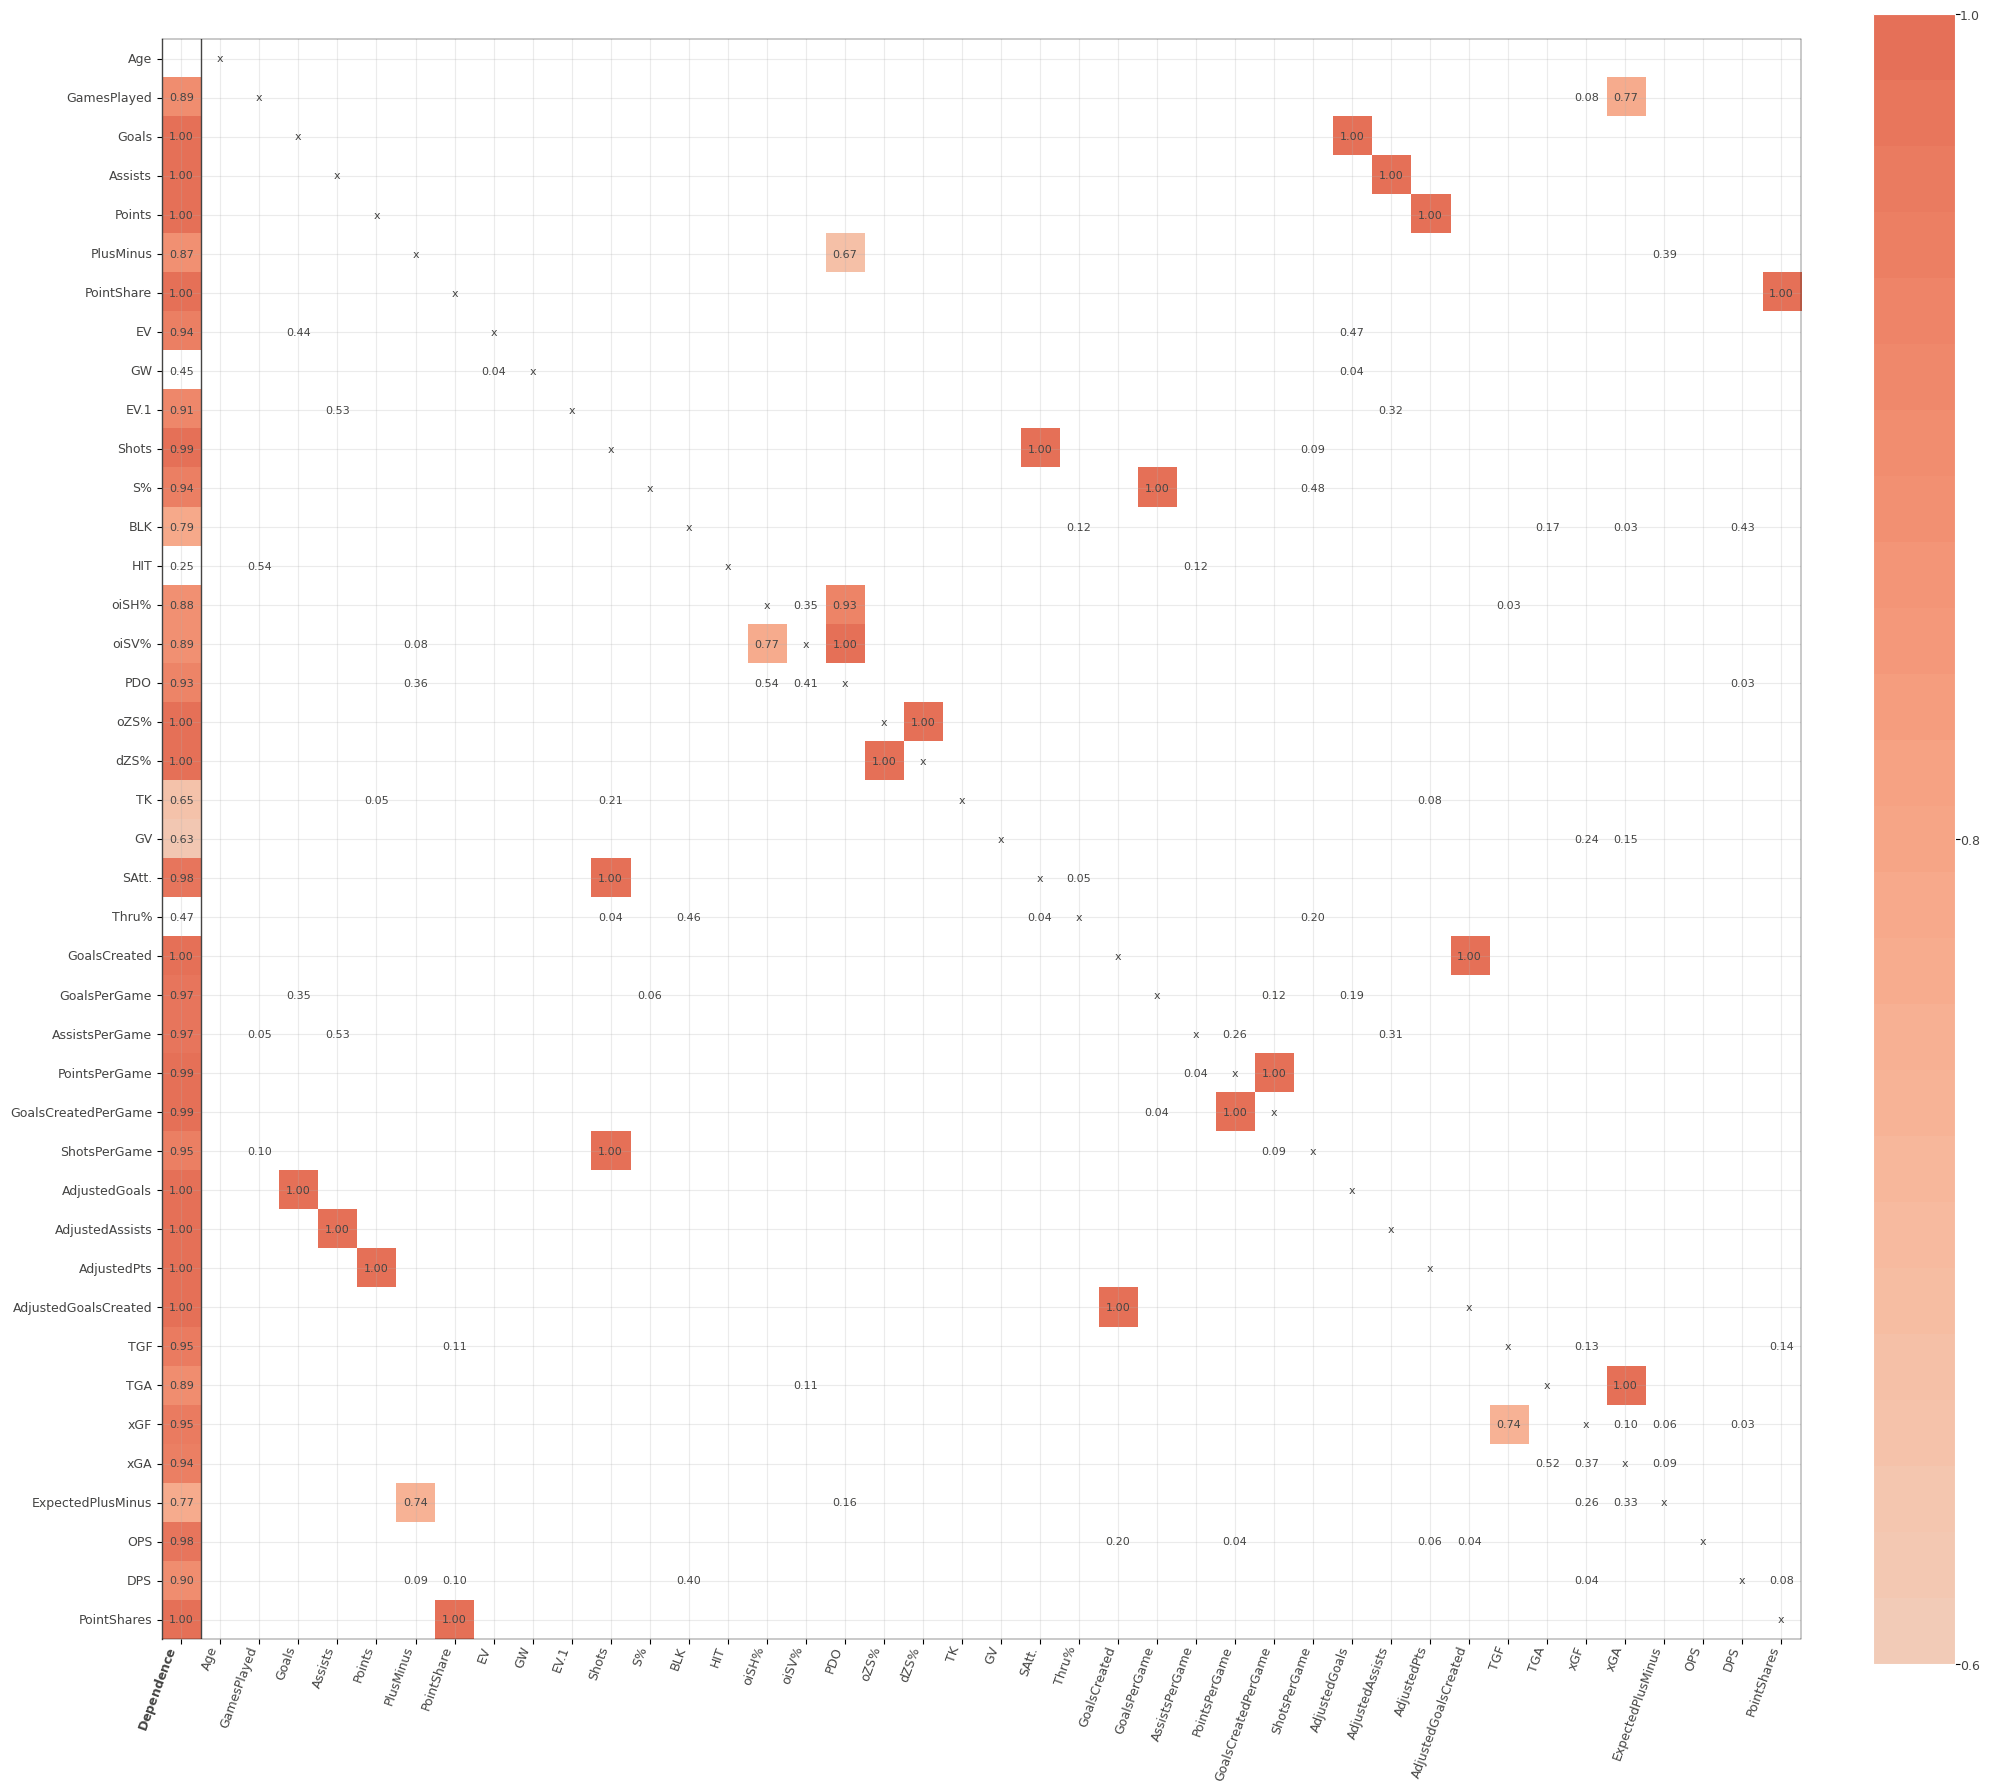

In [19]:
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    figsize=(20,20)
)

fig = plt.gcf()

*Figure 5: Collinear column analysis shows high collinearity problems among an assortment of features.*

The collinear column analysis confirms a lot of what VIF analysis suggests to us as far as the collinearity of the remaining features in the dataset.

We have some options to handle the problem. We can go through the VIF analysis again, dropping the perfectly correlated variables in addition to variables that have a high VIF score. We can also go back and remove more features that perhaps do not add value to the analysis. We could continue this process over and over again until the problem is better addressed, but that is a longer, more tedious process. 

We could do some sort of log transformation to try and counteract the strong correlations. We could also resample using a technique like bootstrapping, essentially creating many more samples by replacement resampling. However, that's just not that much fun (and besides the random forest we are using will naturally use bootstrapping). 

What is fun however, is PCA and Lasso Regression. Both are really useful in handling datasets with high multicollinearity. Lasso regression will penalize least important features and move their regression coefficients closer to zero. Meanwhile, PCA So lets give those a shot then.

<a id="10"></a> <br>
## Lasso Regression Part 1
[back to the top](#0)

In [20]:
las_reg = LassoLarsCV(
    cv = 5,
    max_n_alphas = 1000,
)

las_reg.fit(X_train, y_train)

LassoLarsCV(cv=5)

Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

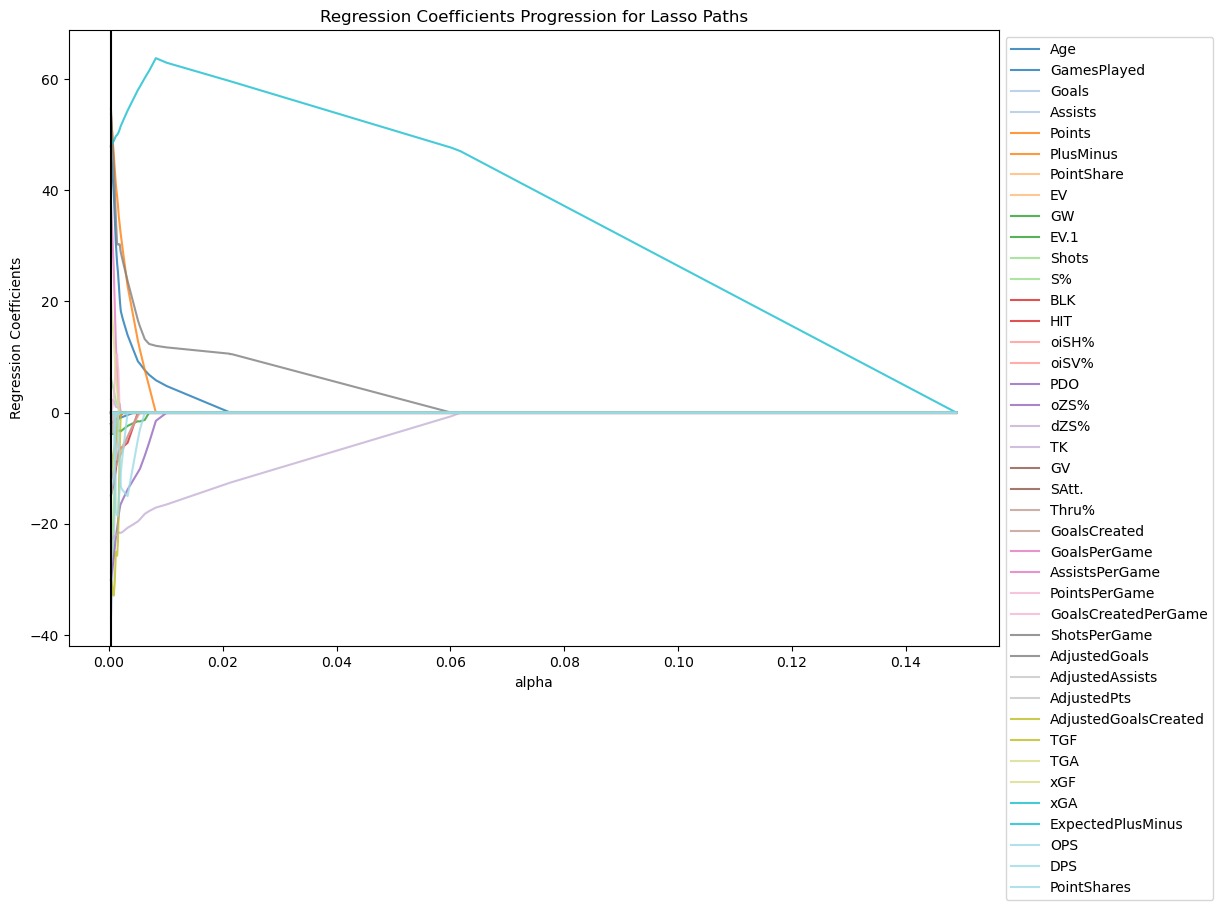

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
cm = iter(
    plt.get_cmap("tab20")(
        np.linspace(0, 1, X_train.shape[1])
    )
)
for i in range(X_train.shape[1]):
    c = next(cm)
    ax.plot(
        las_reg.alphas_,
        las_reg.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X_train.columns[i],
    )
ax.axvline(
    las_reg.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)
plt.ylabel("Regression Coefficients")
ax.legend(X_train.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Regression Coefficients Progression for Lasso Paths"
)

*Figure 6: A bit harder to interpret given the number of variables and the small alpha sizes, but our Lasso Path plot shows a likely low "best" alpha.*

The preceding plot helps visualize our potential alpha value for the lasso regression. As we can see, a good number of our explanatory features converge to zero below 0.02. 

In [22]:
las_reg.alpha_

0.0003491758778932683

The determined best alpha is 0.0005 which is a miniscule value.

In [23]:
las_reg_best = Lasso(alpha=las_reg.alpha_)
las_reg_best.fit(X_train, y_train)

Lasso(alpha=0.0003491758778932683)

In [24]:
las_df = pd.DataFrame(zip(las_reg_best.coef_, df))

In [25]:
las_df.sort_values([0], ascending=False)

,0,1
25,12.433,GoalsCreated
28,3.942,PointsPerGame
38,0.419,xGA
40,0.233,OPS
37,0.214,xGF
5,0.179,Points
1,0.148,Age
17,0.104,oiSV%
2,0.104,GamesPlayed
11,0.084,Shots


In [26]:
r2_las_reg_hd = las_reg_best.score(X_test, y_test)
predictions_las_reg_hd = las_reg_best.predict(X_test)
mse_las_reg_hd = mean_squared_error(y_test, predictions_las_reg_hd)

print(r2_las_reg_hd)
print(mse_las_reg_hd)

0.6851153178032727
5.717849279063303


The resulting coefficients for our features are given above with some interesting results. For example, **PointsPerGame**, **GoalCreatedPerGame**, **Giveaways (GV)**, and **Hits (HIT)** all have extremely low or 0 coefficients suggesting that there is no relationship between these variables and **CF%**. **HIT** is not all that surprising given that if you are throwing hits in a game that likely means you don't have control of the puck. However, I would think giveaways would play a factor in CF% since a giveaway is suggesting that you are not controlling play.  

Our three highest coefficients are **ShotsPerGame**, **AssistsPerGame**, and **Offensive Point Share (OPS)**. I wonder what will result from Principal Component Analysis then. PCA, a lot like lasso, does well with managing high multicollinearity and reducing dimensionality, while preserving the variance of the dataset. We'll specify the n_components parameter as .95 to maintain 95% of the dataset's variance.

<a id="11"></a> <br>
## Principal Component Analysis Part 1
[back to the top](#0)

In [93]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [94]:
pca = PCA(n_components=.95)
pca_x = pca.fit_transform(StandardScaler().fit_transform(X))

pca.explained_variance_ratio_


array([0.56473415, 0.12325197, 0.06639478, 0.05381341, 0.0321607 ,
       0.02770042, 0.02105296, 0.01952512, 0.01589012, 0.01423439,
       0.01284338])

In [95]:
abs(pca.components_[0])

array([0.00803555, 0.12881889, 0.18240927, 0.19270858, 0.20424465,
       0.08812783, 0.19442121, 0.17584577, 0.15831546, 0.18944602,
       0.19018053, 0.10244644, 0.03014962, 0.00094785, 0.13804856,
       0.05334802, 0.07544135, 0.09635711, 0.09635099, 0.16031456,
       0.1425485 , 0.1883979 , 0.02421133, 0.20232619, 0.16761857,
       0.18287904, 0.19510716, 0.19180173, 0.17336262, 0.18244106,
       0.1926048 , 0.20419595, 0.20211029, 0.19624243, 0.129399  ,
       0.16601724, 0.13331707, 0.1017204 , 0.198116  , 0.09817166,
       0.19442121])

[Text(0.5, 0, 'Component'),
 Text(0, 0.5, 'Percent of Explained variance'),
 Text(0.5, 1.0, 'Scree Plot'),
 (0.0, 1.0)]

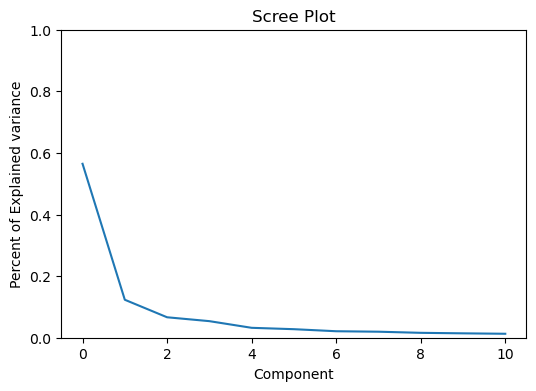

In [96]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pca.explained_variance_ratio_)
ax.set(
    xlabel="Component",
    ylabel="Percent of Explained variance",
    title="Scree Plot",
    ylim=(0, 1),
)

*Figure 7: Scree Plot*

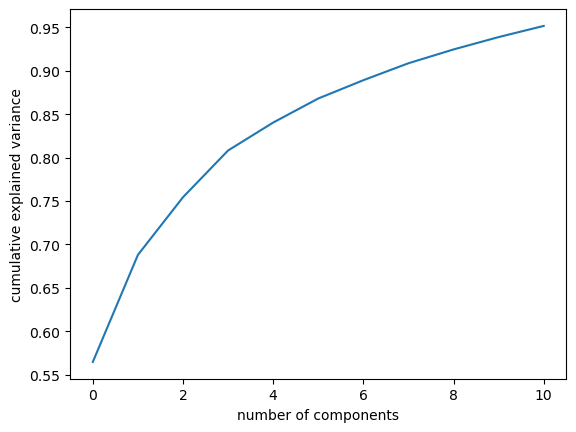

In [97]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

*Figure 8: Hard to really see the elbow here for our principal components. Best let the computer figure that out for us.*

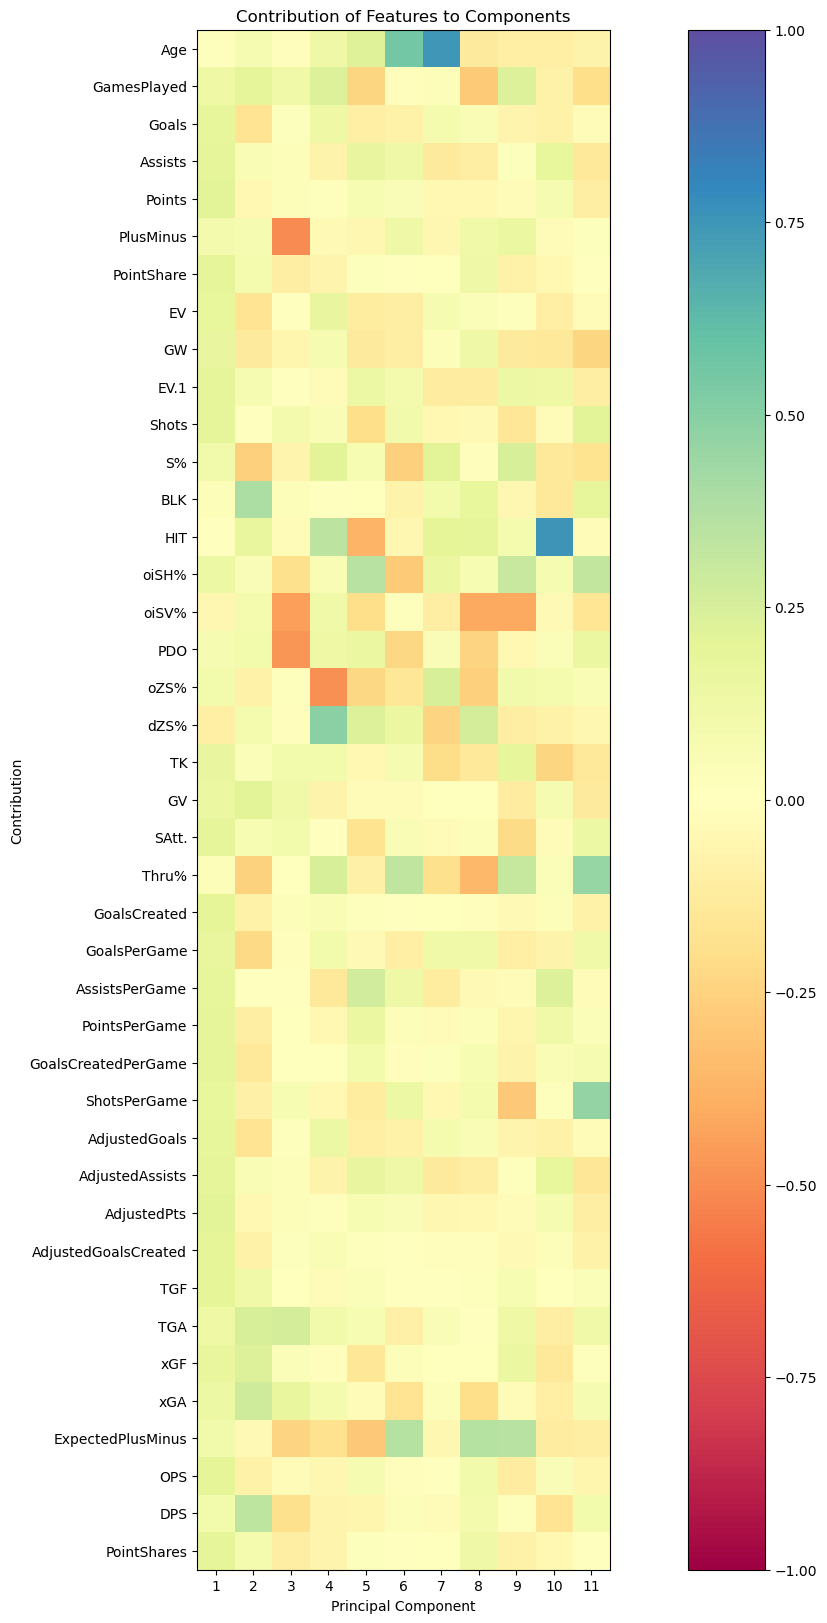

In [98]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(
    pca.components_.T,
    cmap="Spectral",
    vmin=-1,
    vmax=1,
)
plt.yticks(range(len(X.columns)), X.columns)
plt.xticks(range(11), range(1, 12))
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title(
    "Contribution of Features to Components"
)
plt.colorbar()

*Figure 9: Here we get to see the contribution of each feature relative the principal component. Feature like HIT and AGE have a high contribution to the 10th and 7th components respectively*

Fascinating, it seems that PCA was able to reduce the components of the dataset down significantly, and with the above plot we can see how each feature contributes to the principal components.

For example, for the 7th principal component suggests a high contribution for the feature **Age** (.75) while the 10th principal component grades **HIT** highly as well (also around .75). 

What we can now do, is take the results of the PCA model and fit them to our training and test data to then produce new predictive regression models. 

<a id="12"></a> <br>
# Model Building
[back to the top](#0)

<a id="13"></a> <br>
## Random Forest Regressor with PCA Transformed Data
[back to the top](#0)

In [99]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [101]:
print(X_train.shape)
print(X_test.shape)
print(X_train_pca.shape)
print(X_test_pca.shape)

(540, 41)
(181, 41)
(540, 11)
(181, 11)


Well this is interesting, when applying the PCA model to our training and test data, it reduced the dimensions from 41 to 11. I'm not sure that bodes well for the resulting model. 

In [35]:
rf = RandomForestRegressor(
    n_estimators = 1000,
    bootstrap = True,
    n_jobs = 2,
    verbose = 1
)

In [36]:
rf.fit(X_train_pca, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.1s finished


RandomForestRegressor(n_estimators=1000, n_jobs=2, verbose=1)

In [37]:
predictions_rf = rf.predict(X_test_pca)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [38]:
mse_rf_pca_95c = mean_squared_error(y_test, predictions_rf)
mean_squared_error(y_test, predictions_rf)

6.812584649889511

In [39]:
# This is residual sum of squares.
r2_rf_pca_95c = rf.score(X_test_pca, y_test)
r2_rf_pca_95c

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.6248277197033455

In [40]:
rf_results_data = {"Predicted": predictions_rf, "Actual": y_test, "Difference(Abs)": abs(predictions_rf - y_test)}

rf_pred_df = pd.DataFrame(data=rf_results_data)
rf_pred_df.sort_values(["Difference(Abs)"], ascending=False).head()

,Predicted,Actual,Difference(Abs)
491,51.567,58.500,6.933
64,46.480,53.400,6.920
84,46.666,40.200,6.466
341,49.087,55.200,6.113
42,49.340,43.500,5.840


Yikes.

It seems like training and test data that was preprocessed by our PCA work produced a rather poor model with a large Mean Square Error that indicates our predictions can be off by as much as 6. This is punctuated by a poor Residual Sum of Squares score of .62. 

You can see in the previous dataframe, that there are quite a few predictions that are way off the mark.

It makes me wonder if attempting to keep only 95% of variance in the PCA dataset was enough. It is an idea that we can come back to later. 

For now, lets try a simple linear regression. 

<a id="14"></a> <br>
## Standard Ordinary Least Squares Regression
[back to the top](#0)

In [41]:
ols = LinearRegression()
ols.fit(X_train_pca, y_train)

LinearRegression()

In [42]:
ols.coef_

array([ 0.00502299, -0.01979874,  0.04556176, -0.1428291 , -0.16748053,
        0.14438936, -0.00679748,  0.14622502,  0.1604434 , -0.05481178,
       -0.05032886])

In [43]:
ols.intercept_

74.28704372893631

In [44]:
predictions = ols.predict(X_test_pca)

In [45]:
r2_ols_pca = ols.score(X_test_pca, y_test)
r2_ols_pca

0.6684660949429537

In [46]:
mse_ols_pca = mean_squared_error(y_test, predictions)
mse_ols_pca

6.020175026586847

<a id="15"></a> <br>

### Using StatsModels Tools
[back to the top](#0)

In [47]:
X_ols = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_ols).fit()

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CF%   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     114.8
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          3.05e-132
Time:                        20:59:47   Log-Likelihood:                -1237.6
No. Observations:                 540   AIC:                             2499.
Df Residuals:                     528   BIC:                             2551.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.2870      3.064     24.244      0.000      68.268      80.306
x1             0.0050      0.007      0.743      0.458      -0.008       0.018
x2            -0.0198      0.008     -2.505      0.013      -0.035      -0.004
x3             0.0456      0.014      3.332      0.001       0.019       0.072
x4            -0.1428      0.009    -15.113      0.000      -0.161      -0.124
x5            -0.1675      0.012    -14.158      0.000      -0.191      -0.144
x6             0.1444      0.018      7.981      0.000       0.109       0.180
x7            -0.0068      0.020     -0.333      0.740      -0.047       0.033
x8             0.1462      0.018      8.060      0.000       0.111       0.182
x9             0.1604      0.015     10.704      0.000       0.131       0.190
x10           -0.0548      0.009     -5.771      0.000      -0.073      -0.036
x11           -0.0503      0.019     -2.625      0.009      -0.088      -0.013
==============================================================================
Omnibus:                        6.427   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.654
Skew:                          -0.140   Prob(JB):                       0.0218
Kurtosis:                       3.511   Cond. No.                     7.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
print('Parameters: ', model.params)
print('R2: ', model.rsquared)

Parameters:  const   74.287
x1       0.005
x2      -0.020
x3       0.046
x4      -0.143
x5      -0.167
x6       0.144
x7      -0.007
x8       0.146
x9       0.160
x10     -0.055
x11     -0.050
dtype: float64
R2:  0.7051737423937559


The results of our ordinary least squares regression are comparable to our random forest regression with lower than desired R squared scores and reduced dimensions that have miniscule P-values. So what to do?

<a id="16"></a> <br>

# Re- Evaluating and Improving Models
[back to the top](#0)

We could adjust the PCA model to raise the variance accounted for from 95% to 100%. 

We could also go back to our VIF analysis, remove the infinite and high VIF scores, and rerun our lasso regression in addition to the collinear column analysis to see what changed. 

We could also pull in other SKlearn techniques like mutual information analysis or recursive feature elimination to do further feature selection.  

Under different circumstancese we would likely do a combination of all these options. However, I want the outputs of these models to be little more readable (as opposed to x1, x2 etc.) so lets drop PCA for now. We will go with the second option an see what improvements can be made while maintaining more detail and reading of our features. 

So lets do the VIF analysis again, this time dropping the infinite vif value features. Then we can remove features that have high VIF scores.

<a id="17"></a> <br>

## Variable Inflation Factor Analysis Part 2
[back to the top](#0)

In [50]:
features_to_drop_2 = ["Goals", "Assists", "Points", "PointShare", "AdjustedGoals", "AdjustedAssists", "AdjustedPts", "PointShares", "GamesPlayed", "xGF", "PDO", "oiSV%", "PointsPerGame", "GoalsCreatedPerGame", "AdjustedGoalsCreated", 
                      "Shots","oZS%", "dZS%", "GoalsCreated", "xGA", "ShotsPerGame", "GoalsPerGame", "TGF", "TGA", "Thru%", "AssistsPerGame", "SAtt.", "oiSH%", "EV.1", "EV", "DPS"]

X_train_ = X_train.drop(features_to_drop_2, axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_.values, i) for i in range(len(X_train_.columns))]

In [51]:
X_test_ = X_test.drop(features_to_drop_2, axis=1)

In [52]:
vif_data

,feature,VIF
0,Age,10.068
1,PlusMinus,2.011
2,GW,4.832
3,S%,7.559
4,BLK,4.991
5,HIT,3.868
6,TK,7.282
7,GV,9.491
8,ExpectedPlusMinus,2.075
9,OPS,6.946


So I went through the tedious process of removing high scoring VIF features one by one (though you will see more streamlined code above) until I was able to produce a satisfactory data set with VIF scores < 10 (cheating with age but only just). Lets see how this impacts our models.

<a id="18"></a> <br>

## Lasso Regression Part 2 (Low Dimensional Features)
[back to the top](#0)

In [53]:
las_reg = LassoLarsCV(
    cv = 5,
    max_n_alphas = 1000,
)

las_reg.fit(X_train_, y_train)

LassoLarsCV(cv=5)

Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

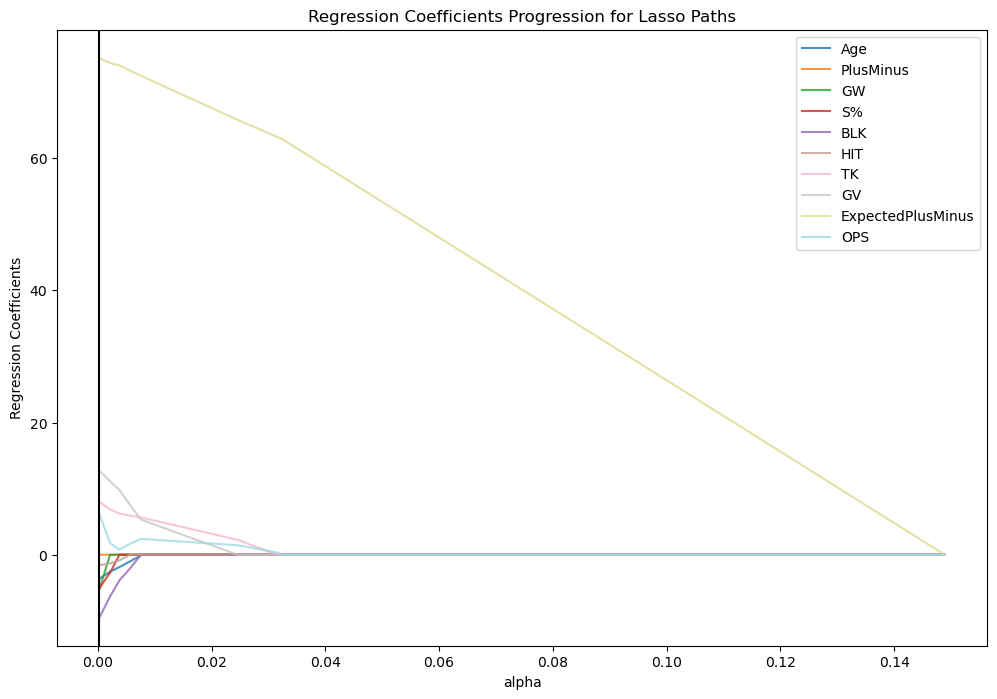

In [54]:
fig, ax = plt.subplots(figsize=(12, 8))
cm = iter(
    plt.get_cmap("tab20")(
        np.linspace(0, 1, X_train_.shape[1])
    )
)
for i in range(X_train_.shape[1]):
    c = next(cm)
    ax.plot(
        las_reg.alphas_,
        las_reg.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X_train_.columns[i],
    )
ax.axvline(
    las_reg.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)
plt.ylabel("Regression Coefficients")
ax.legend(X_train_.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Regression Coefficients Progression for Lasso Paths"
)

*Figure 9: Another really low alpha.* 

In [55]:
las_reg.alpha_

0.00026497391469331317

In [56]:
las_reg_best = Lasso(alpha=las_reg.alpha_)
las_reg_best.fit(X_train_, y_train)

Lasso(alpha=0.00026497391469331317)

In [57]:
las_df = pd.DataFrame(zip(las_reg_best.coef_, df))
las_df.sort_values([0], ascending=False)

,0,1
8,0.400,EV
9,0.135,GW
7,0.030,PointShare
6,0.023,PlusMinus
5,-0.001,Points
1,-0.001,Age
4,-0.012,Assists
0,-0.039,Player
3,-0.046,Goals
2,-0.127,GamesPlayed


In [58]:
las_reg_best.score(X_test_, y_test)

0.6047541576692682

In [59]:
r2_las_reg = las_reg_best.score(X_test_, y_test)
predictions_las_reg = las_reg_best.predict(X_test_)
mse_las_reg = mean_squared_error(y_test, predictions_las_reg)

print(r2_las_reg)
print(mse_las_reg)

0.6047541576692682
7.177091431877313


Hmm, not much of an improvement over the previous Lasso regression, but that could have to do with running the analysis on a much more sparse dataset in terms of features. Plus, we theoretically removed a significant level multicollinearity in the previous VIF step.

Lets skip to the OLS regression and see what happens there. 

<a id="19"></a> <br>

## Ordinary Least Squares Regression (Low Dimension and Polynomial Regression)
[back to the top](#0)

In [60]:
X_ols = sm.add_constant(X_train_)
model = sm.OLS(y_train, X_ols).fit()

In [61]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CF%   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     96.25
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          3.13e-112
Time:                        20:59:47   Log-Likelihood:                -1287.5
No. Observations:                 540   AIC:                             2597.
Df Residuals:                     529   BIC:                             2644.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                50.2355      0.828     60.680      0.000      48.609      51.862
Age                  -0.0390      0.028     -1.412      0.159      -0.093       0.015
PlusMinus            -0.0015      0.011     -0.131      0.896      -0.023       0.021
GW                   -0.1271      0.097     -1.315      0.189      -0.317       0.063
S%                   -0.0462      0.032     -1.451      0.147      -0.109       0.016
BLK                  -0.0115      0.004     -2.666      0.008      -0.020      -0.003
HIT                  -0.0013      0.002     -0.544      0.587      -0.006       0.003
TK                    0.0227      0.011      2.118      0.035       0.002       0.044
GV                    0.0297      0.010      2.918      0.004       0.010       0.050
ExpectedPlusMinus     0.4001      0.020     19.758      0.000       0.360       0.440
OPS                   0.1351      0.111      1.218      0.224      -0.083       0.353
==============================================================================
Omnibus:                        9.719   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.444
Skew:                          -0.157   Prob(JB):                      0.00120
Kurtosis:                       3.706   Cond. No.                         846.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
print('Parameters: ', model.params)
print('R2: ', model.rsquared)

Parameters:  const               50.236
Age                 -0.039
PlusMinus           -0.001
GW                  -0.127
S%                  -0.046
BLK                 -0.012
HIT                 -0.001
TK                   0.023
GV                   0.030
ExpectedPlusMinus    0.400
OPS                  0.135
dtype: float64
R2:  0.6453329381045174


Here again, we have a scenario where we get a lower R2 score (and adjusted R2) compared to the previous work when utilizing PCA. Though, we do get a little bit more detail here where it seems like the variables **BLK (blocked shots)**, **TK (takeaways)**, **GV (giveaways)**, and **ExpectedPlusMinus** are statistically significant at at least a 0.05 signficance level. Lets see what the model looks like if we just keep those variables.

In [63]:
significant_variables = X_train_[["BLK", "TK", "GV", "ExpectedPlusMinus"]]

In [64]:
X_ols = sm.add_constant(significant_variables)
model = sm.OLS(y_train, X_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CF%   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     238.1
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          2.76e-117
Time:                        20:59:47   Log-Likelihood:                -1291.2
No. Observations:                 540   AIC:                             2592.
Df Residuals:                     535   BIC:                             2614.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                48.6305      0.251    193.685      0.000      48.137      49.124
BLK                  -0.0099      0.004     -2.665      0.008      -0.017      -0.003
TK                    0.0183      0.010      1.888      0.060      -0.001       0.037
GV                    0.0321      0.009      3.562      0.000       0.014       0.050
ExpectedPlusMinus     0.3994      0.015     26.913      0.000       0.370       0.429
==============================================================================
Omnibus:                        6.500   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                8.322
Skew:                          -0.108   Prob(JB):                       0.0156
Kurtosis:                       3.568   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
print('Parameters: ', model.params)
print('R2: ', model.rsquared)

Parameters:  const               48.630
BLK                 -0.010
TK                   0.018
GV                   0.032
ExpectedPlusMinus    0.399
dtype: float64
R2:  0.6403281289875453


Hmm, it seems like there was little change in the R2 scores. If anything, the scores fell by an albeit inconsequential amount. Still I was expecting a little bit of an improvement here. Even the Akaike Score and the Bayesian Information Crietrion score remain the relatively similar. Though, these scores are lower for model with less variables suggesting that this model is slightly better than the previous. 

Lets try a polynomial regression just for kicks.

In [66]:
poly_feat = PolynomialFeatures(degree=3)
xp = poly_feat.fit_transform(significant_variables)

In [67]:
model_ = sm.OLS(y_train, xp).fit()

In [68]:
model_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CF%   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     38.13
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          4.14e-117
Time:                        20:59:48   Log-Likelihood:                -1224.0
No. Observations:                 540   AIC:                             2518.
Df Residuals:                     505   BIC:                             2668.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.3038      0.628     76.949      0.000      47.071      49.537
x1            -0.0660      0.029     -2.278      0.023      -0.123      -0.009
x2             0.0410      0.074      0.552      0.581      -0.105       0.187
x3             0.1228      0.060      2.029      0.043       0.004       0.242
x4             1.0170      0.083     12.299      0.000       0.855       1.179
x5             0.0007      0.000      1.689      0.092      -0.000       0.001
x6          3.497e-05      0.001      0.029      0.977      -0.002       0.002
x7          7.262e-08      0.001   6.65e-05      1.000      -0.002       0.002
x8            -0.0041      0.002     -2.534      0.012      -0.007      -0.001
x9             0.0028      0.003      0.979      0.328      -0.003       0.008
x10           -0.0051      0.003     -1.791      0.074      -0.011       0.000
x11           -0.0171      0.005     -3.219      0.001      -0.028      -0.007
x12            0.0003      0.002      0.162      0.871      -0.004       0.004
x13           -0.0059      0.004     -1.592      0.112      -0.013       0.001
x14            0.0075      0.005      1.614      0.107      -0.002       0.017
x15        -1.855e-06   1.77e-06     -1.049      0.295   -5.33e-06    1.62e-06
x16        -3.655e-06   7.63e-06     -0.479      0.632   -1.86e-05    1.13e-05
x17         5.346e-09   5.36e-06      0.001      0.999   -1.05e-05    1.05e-05
x18         3.426e-06   9.78e-06      0.350      0.726   -1.58e-05    2.26e-05
x19         9.388e-06   1.93e-05      0.486      0.627   -2.86e-05    4.74e-05
x20         3.487e-06   2.42e-05      0.144      0.886   -4.41e-05     5.1e-05
x21         1.957e-06   3.74e-05      0.052      0.958   -7.16e-05    7.55e-05
x22        -5.024e-06   1.46e-05     -0.343      0.732   -3.38e-05    2.37e-05
x23         5.357e-05   3.06e-05      1.749      0.081   -6.61e-06       0.000
x24        -2.027e-05   3.95e-05     -0.514      0.608   -9.78e-05    5.73e-05
x25        -1.995e-05   3.46e-05     -0.576      0.565    -8.8e-05    4.81e-05
x26        -2.635e-05    5.1e-05     -0.517      0.605      -0.000    7.38e-05
x27            0.0001   9.11e-05      1.631      0.104   -3.04e-05       0.000
x28         5.202e-05   3.31e-05      1.570      0.117   -1.31e-05       0.000
x29         8.745e-05      0.000      0.760      0.447      -0.000       0.000
x30         1.568e-05      0.000      0.122      0.903      -0.000       0.000
x31        -6.213e-06   1.69e-05     -0.368      0.713   -3.94e-05     2.7e-05
x32        -1.957e-05    6.8e-05     -0.288      0.774      -0.000       0.000
x33           -0.0001   8.45e-05     -1.414      0.158      -0.000    4.65e-05
x34           -0.0002   9.49e-05     -1.755      0.080      -0.000    1.99e-05
==============================================================================
Om

So we achieved somewhat of an improvement with higher R2 and adjusted R2 scores compared to the non-polynomial models. The Akaike score is lower as well, but the beysian information criterion is the highest of the three models. 

Lets check out a new Random Forest model then and see how that performs with a less collinear dataset. 

<a id="20"></a> <br>

## Random Forest Regressor (Low Dimensional Features)
[back to the top](#0)

In [69]:
r2_poly_reg = model_.rsquared_adj
mse_poly_reg = model_.mse_resid

In [70]:
rf_ = RandomForestRegressor(
    n_estimators = 1000,
    bootstrap = True,
    n_jobs = 2,
    verbose = 1
)

In [71]:
rf_.fit(X_train_, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.0s finished


RandomForestRegressor(n_estimators=1000, n_jobs=2, verbose=1)

In [72]:
predictions_rf = rf_.predict(X_test_)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [73]:
mse_rf_ld = mean_squared_error(y_test, predictions_rf)
mse_rf_ld

5.1709859265745575

In [74]:
r2_rf_ld = rf_.score(X_test_, y_test)
r2_rf_ld

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.7152313429989674

In [75]:
rf_results_data = {"Predicted": predictions_rf, "Actual": y_test, "Difference(Abs)": abs(predictions_rf - y_test)}

rf_pred_df = pd.DataFrame(data=rf_results_data)
rf_pred_df.sort_values(["Difference(Abs)"], ascending=False).head()

,Predicted,Actual,Difference(Abs)
79,47.196,39.100,8.096
103,45.010,52.200,7.190
593,52.776,58.700,5.924
64,47.609,53.400,5.791
491,52.960,58.500,5.540


It seems like this new Random Forest regressor has produced a better model than its competitor that was trained on PCA transformed data given that the R2 score has gone from .62 to .71 with this new model. Furthermore, the mean_squared_error is a full point lower. Meaning the degree to which our predictions are off will be lesser so with this new forest. 

Lets take a look at a tree in our Random Forest. *Note: In order to visualize the tree, I had to retrain the model to use a max_depth of 3 so it was readable.*

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished


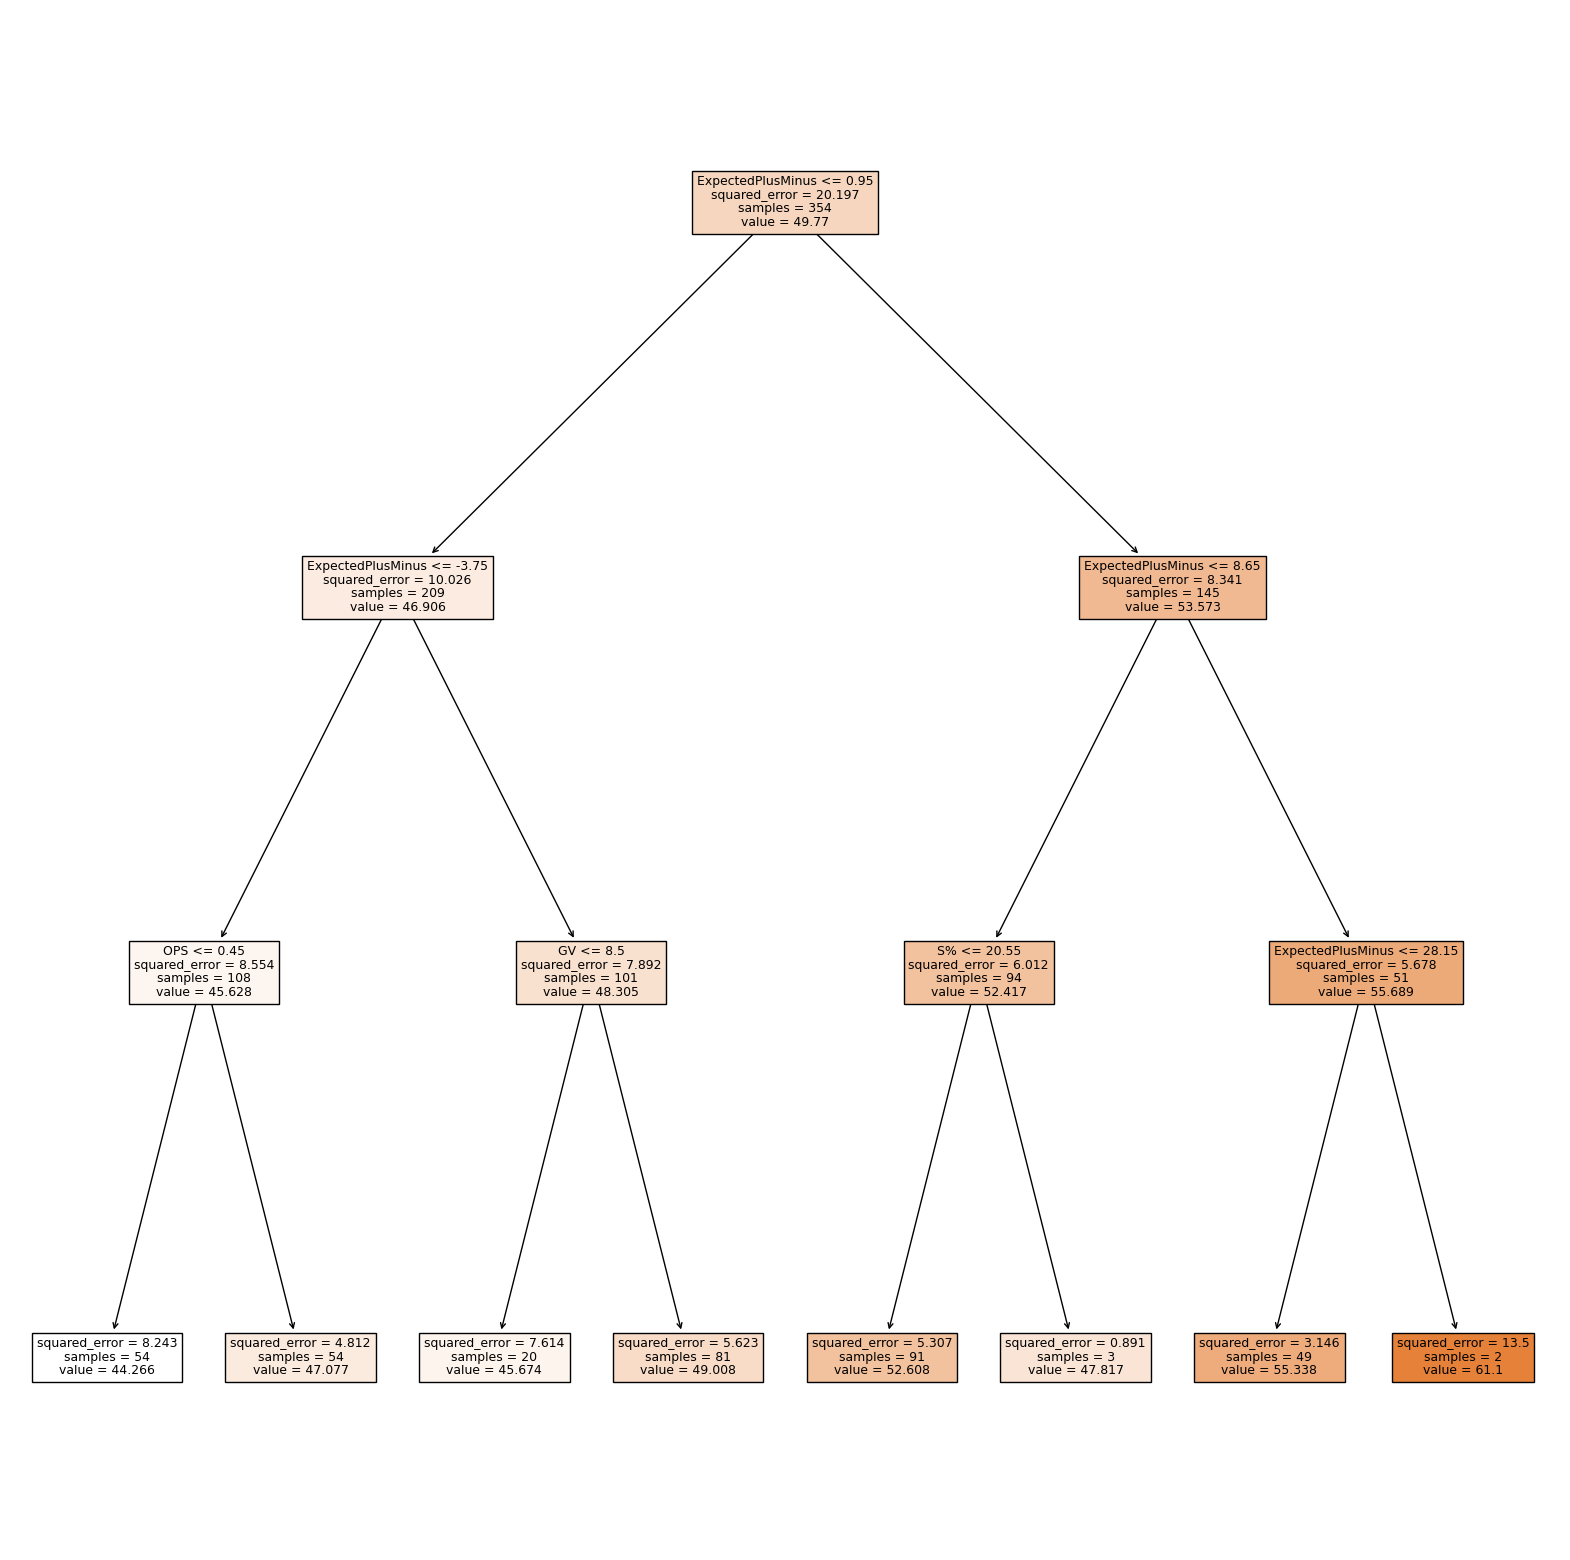

In [76]:
rf_ = RandomForestRegressor(
    n_estimators = 1000,
    bootstrap = True,
    n_jobs = 2,
    verbose = 1, 
    max_depth = 3
)

rf_.fit(X_train_, y_train)

plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf_.estimators_[0], feature_names=X_train_.columns, filled=True)

*Figure 10: The regression decision tree for our first estimator. Expected Plus/Minus looks to play a big factor in where this tree goes.*

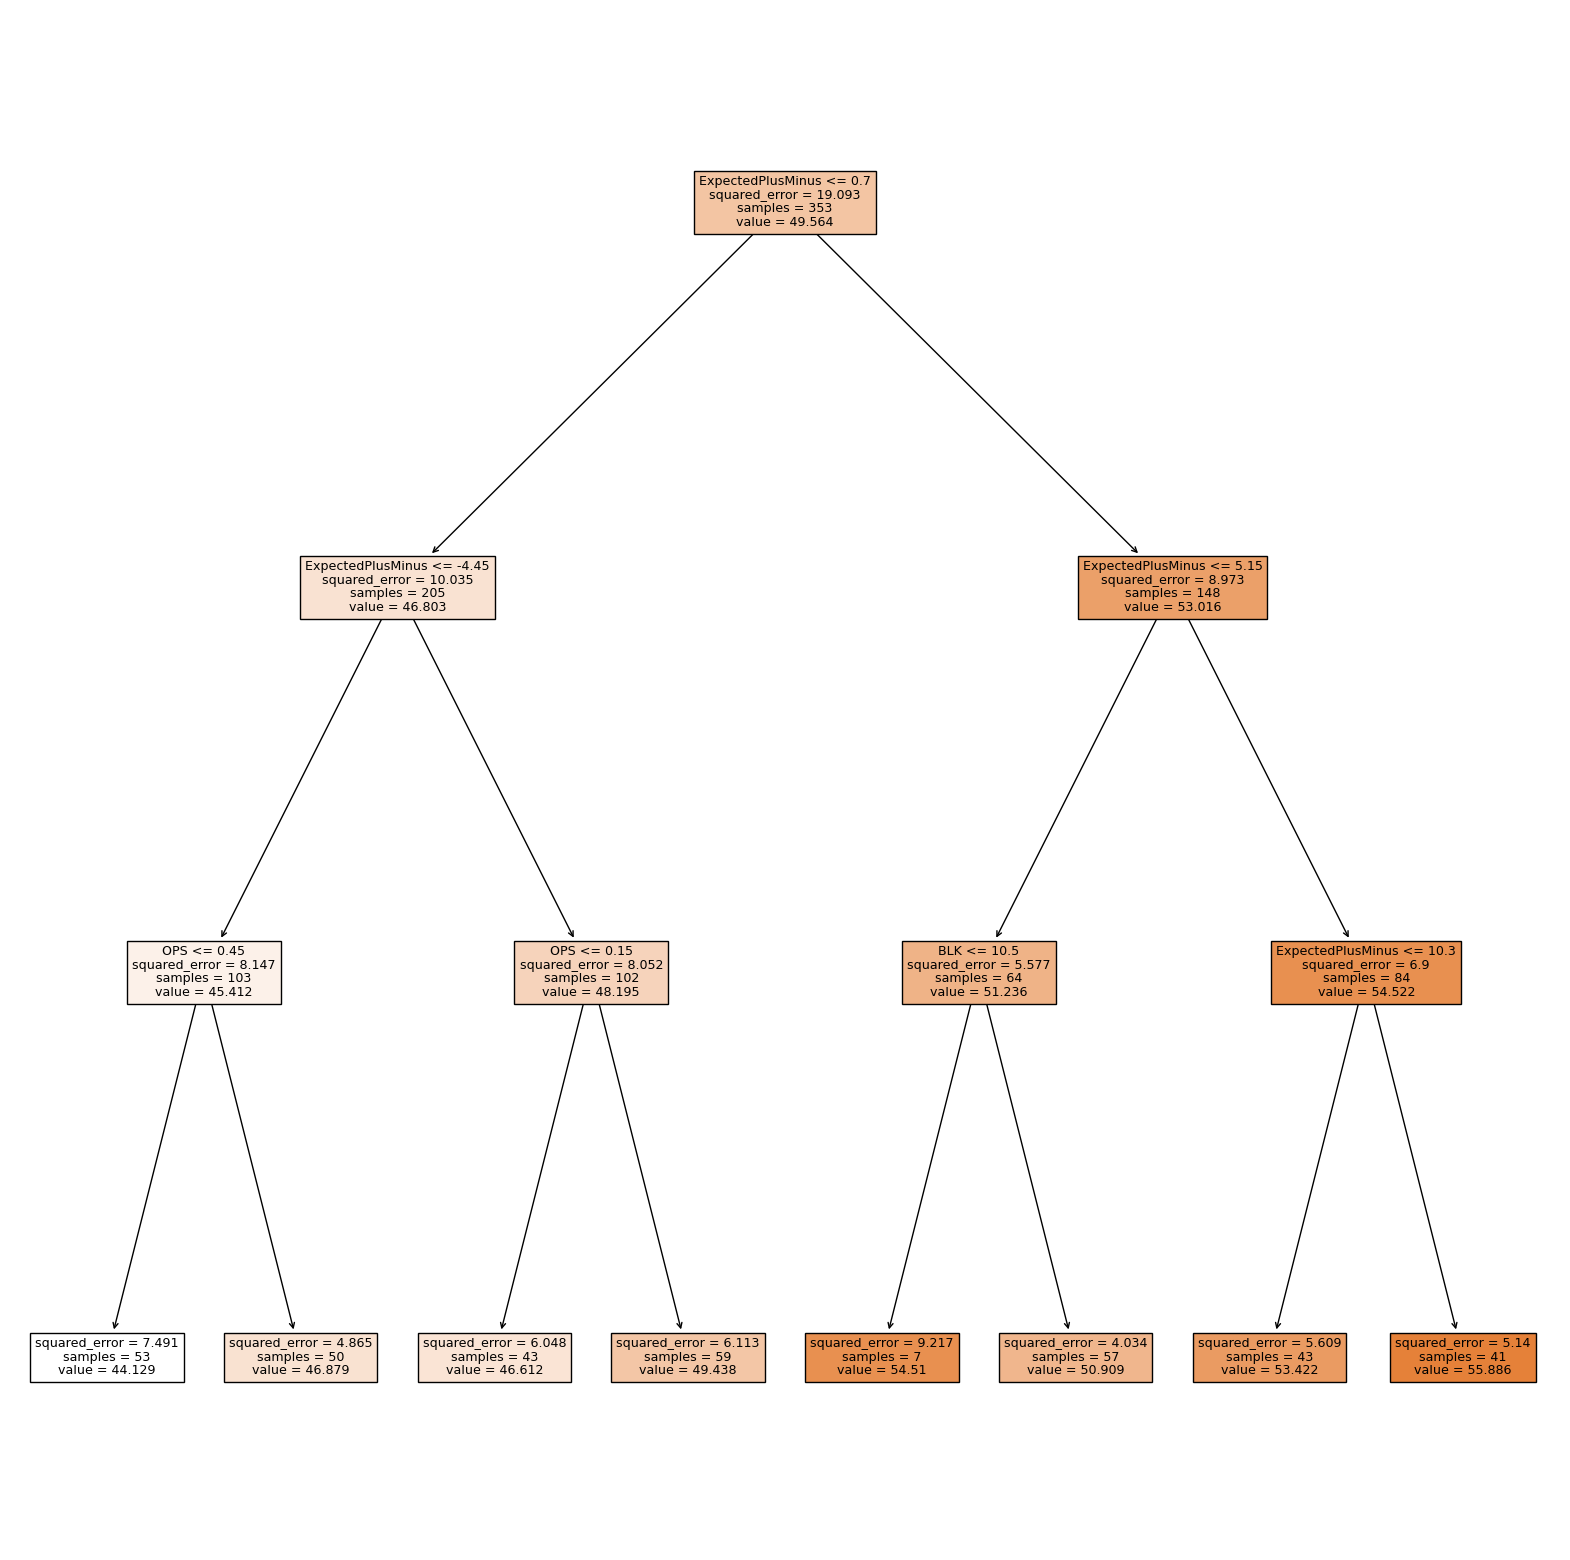

In [77]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf_.estimators_[2], feature_names=X_train_.columns, filled=True)

*Figure 11: Same as the above for the next decision tree.*

Before we conclude. Lets just take one last look at PCA. I'm curious what would happen if I did not limit n_components to only 95% variance on the dataset. 

<a id="21"></a> <br>

## With PCA no n_components Flag
[back to the top](#0)

In [78]:
# Making sure are using all the features again.
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [79]:
pca = PCA()
pca_x = pca.fit_transform(StandardScaler().fit_transform(X))

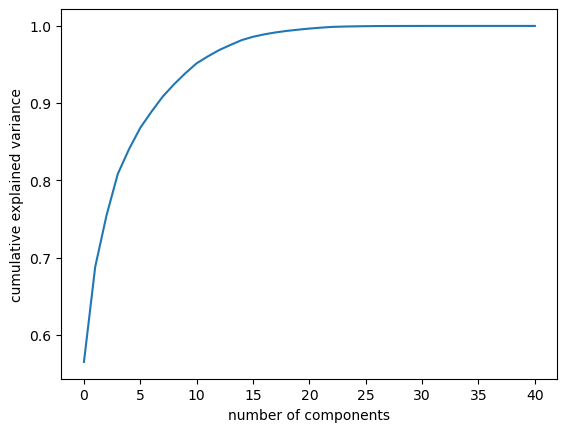

In [80]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [81]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [82]:
print(X_train.shape)
print(X_test.shape)
print(X_train_pca.shape)
print(X_test_pca.shape)

(540, 41)
(181, 41)
(540, 41)
(181, 41)


In [83]:
rf = RandomForestRegressor(
    n_estimators = 1000,
    bootstrap = True,
    n_jobs = 2,
    verbose = 1
)

In [84]:
rf.fit(X_train_pca, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.7s finished


RandomForestRegressor(n_estimators=1000, n_jobs=2, verbose=1)

In [85]:
predictions_rf = rf.predict(X_test_pca)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.0s finished


In [86]:
mse_rf_pca = mean_squared_error(y_test, predictions_rf)
mse_rf_pca

5.251214790607701

In [87]:
r2_rf_pca = rf_.score(X_test_, y_test)
r2_rf_pca

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.6937578176516552

In [88]:
rf_results_data = {"Predicted": predictions_rf, "Actual": y_test, "Difference(Abs)": abs(predictions_rf - y_test)}

rf_pred_df = pd.DataFrame(data=rf_results_data)
rf_pred_df.sort_values(["Difference(Abs)"], ascending=False).head()

,Predicted,Actual,Difference(Abs)
64,46.939,53.400,6.461
79,45.282,39.100,6.182
491,52.464,58.500,6.036
593,52.674,58.700,6.026
856,51.454,57.400,5.946


The resulting PCA-RF model that is not limited by the n_components flag returned a better R2 score and lower MSE than its counterpart. But, the improvements were comparable to the Polynomial regression model and the RF model that was run on a much smaller number of features. In fact, that latter model scored just a tiny bit better than this PCA-RF model did. 

<a id="22"></a> <br>

# Conclusion
[back to the top](#0)

Lets compare our models below:

In [89]:
model_names = ["Lasso Regression (High Dimension)", "Random Forest Regression - PCA (95% Variance Maintained)", "Random Forest Regression - PCA (No Component Flag)","Ordinary Least Squares Regression - PCA (95% Variance Maintained)", 
               "Lasso Regression (Low Dimension)", "Polynomial Regression", "Random Forest Regression (Low Dimension)"]
model_mse = [mse_las_reg_hd, mse_rf_pca_95c, mse_rf_pca, mse_ols_pca, mse_las_reg, mse_poly_reg, mse_rf_ld]
model_r2 = [r2_las_reg_hd, r2_rf_pca_95c, r2_rf_pca, r2_ols_pca, r2_las_reg, r2_poly_reg, r2_rf_ld]

In [90]:
model_compare = pd.DataFrame({"Model": model_names, "Mean Squared Error": model_mse, "R2 Score": model_r2})
model_compare.reset_index(drop=True, inplace=True)

In [91]:
model_compare

,Model,Mean Squared Error,R2 Score
0,Lasso Regression (High Dimension),5.718,0.685
1,Random Forest Regression - PCA (95% Variance M...,6.813,0.625
2,Random Forest Regression - PCA (No Component F...,5.251,0.694
3,Ordinary Least Squares Regression - PCA (95% V...,6.020,0.668
4,Lasso Regression (Low Dimension),7.177,0.605
5,Polynomial Regression,5.826,0.701
6,Random Forest Regression (Low Dimension),5.171,0.715


We started this exercise with around 43 features, 41 of which were considered (the other two were name and team name), and about 1000+ samples that was reduced to 700+ based on a games played threshold. These 41 features were highly correlated with one another, which is not a surprise given that quite of few of these features were calculations of one another. Nevertheless, this means the dataset had a high degree multicollinearity as exemplified in our variable inflation factor(VIF), collinear column, and even in lasso regression analysis. 

I approached the issue from multiple angles. The first was to utilize Lasso Regression and principal component analysis, which are both good for high dimension and highly collinear datasets. Interestingly, the PCA analysis with 95% of variance maintained (PCA/95) reduced the dimensions of the data set from 41 to 11 principal components, but its application to the ensuing Random Forest Regression did not perform as well as the high dimension Lasso regression which scored a lower mean squared error of 5.7 and a higher R2 score of .68 compared to 6.8 and .625 respectively for the PCA-Forest. 

In fact, it seems like when PCA/95% data was used for training and testing the models, those models generally did not show much improvements over competitors. In fact, while rerunning PCA with a Random Forest and no limits on the variance maintained, the model performed better than its PCA/95 counterpart, but it still did not crack the top models as you can see in the table above. Though, it did produce the second lowest mean squared error score of ~5.3; bested only by the low dimension random forest. 

Going back over the data and removing columns to improve VIF scores, produced the best performing models. The Polynomial regression was run on 3 degrees and higher p-value features (blocks, takeaways, giveaways, and ExpectedPlusMinus) and produced the second highest R2 score of .7 along with the 4 lowest mean squared error. The crown, however, goes to the low dimension Random Forest that did not utilize PCA which had the highest R2 score of ~.72 and the lowest mean squared error at 5.171.

<a id="23"></a> <br>

## Possible Improvements and Mistakes
[back to the top](#0)

I'll admit, I was a little unsure of the results while going throught this. At one point I was going over the results and writing everything when I forgot that I needed to set the random seed for the notebook. Then some googling showed that I likely needed to seed numpy as well. I'm not sure if what I did was overkill here or not enough which may influence results. 

Further, when I was going over this the first time, the PCA-Random Forest score without setting variance level produced a model that was in the 90's in terms of R2 score and had a mean squared error of 2. I was surprised when I went to go do the same thing over again and got the .694 R2 score result. It made me question everything I was doing. I would have thought that bootstrapping implemented within the SKLearn method and the standardization I did to the data would have produced a better performing model. 

As far as improvements go, one thing I would like to have done is exhaustive Grid Search. SKLearn has a really nice implementation of exhaustive grid search that will run different model hyperparameters (like the n_estimators, max_depth for random forest regression) to really tune the model and figure out what levers to pull for the best possible model. 